<div align="center">

# TRABAJO FINAL

## Introducción a las Técnicas Inteligentes de Resolución de Problemas de Planificación, Secuenciación y Ejecución

### Maestría en Aplicaciones de Información Espacial

# Evaluación del NDVI en el Embalse Los Molinos Usando Python.
### Fecha de imagen: 11/03/2023

### Alumno: Barra, Camilo Giuliano

##### 2024

</div>



## Introducción
En la creciente necesidad de monitorear los recursos naturales, el uso de tecnologías satelitales se ha vuelto indispensable. Una de las aplicaciones más relevantes en el sensado remoto es el cálculo del Índice de Vegetación de Diferencia Normalizada (NDVI), una herramienta fundamental para la evaluación de la salud de los ecosistemas acuáticos y terrestres.

El NDVI es un indicador que utiliza la reflectancia de la luz en las bandas del rojo y del infrarrojo cercano para determinar la cantidad y vigor de la vegetación presente en una superficie. En el caso de cuerpos de agua, como lagos y embalses, el NDVI puede ser utilizado para evaluar el grado de eutrofización, un proceso de enriquecimiento de nutrientes que puede conducir a la proliferación de algas y a la degradación de la calidad del agua.

En este trabajo final, se propone el desarrollo de un programa en Python para calcular y visualizar el NDVI de una imagen Landsat 8 con fecha del 11/03/2023. El área de estudio seleccionada es el Embalse Los Molinos, en la provincia de Córdoba. El objetivo principal es implementar un algoritmo que permita procesar las imágenes, eliminar las áreas de tierra, y generar una visualización clara y precisa del NDVI únicamente sobre la superficie del lago para evaluar su estado de eutrofización.

El proceso incluye varias etapas: la descompresión de los archivos de imágenes, el análisis exploratorio de los datos, la identificación, la creación de una máscara de agua, el recorte de las bandas y, finalmente, el cálculo y visualización del NDVI. 

## Estructura

Si bien el trabajo completo se encuentra compilado en la presente notebook, es necesario mencionar que se han confeccionado distintos archivos de Python con la finalidad de trabajar de manera cómoda y organizada:
1. **funciones.py** = se han separado todas las funciones utilizadas en un archivo por separado y luego se han importado en otros archivos Python donde son ejecutados.
2. **extraer_zip.py** = se ejecuta la función para extrar el contenido del archivo zip en la carpeta de destino.
3. **atributos.py** = se leen los atributos que conforman las bandas de la imagen seleccionada y se imprime en pantalla. La idea es seleccionar los que son de interés.
4. **metadata.py** = en este archivo se ejecuta la función para leer la metadata de las bandas y almacenar en formato .txt únicamente los atributos seleccionados en previamente.
5. **mndwi.py** = archivo en donde se calcula y visualiza el índice MNDWI del área de estudio completo.
6. **ndvi.py** = archivo en donde se calcula y visualiza el índice NDVI del área de estudio completo.
7. **mascara.py** = se calcula la máscara en base a la condición de aislar los píxeles con índice MNDWI mayor a 0. El resultado es una imagen binaria.
8. **mndwi_con_mascara.py** = se recorta el índice MNDWI al área del lago usando la máscara obtenida previamente.
9.  **ndvi_con_mascara.py** = es el objetivo final del presente trabajo. Se recorta el índice NDVI al área del lago usando la máscara.

## Librerías utlizadas

1. **zipfile** = esta librería proporciona herramientas para trabajar con archivos ZIP. Permite descomprimir, extraer o agregar archivos a un archivo ZIP existente. https://docs.python.org/3/library/zipfile.html
2. **rasterio** = es una librería de Python que facilita la lectura y escritura de datos raster. Permite abrir y manipular conjuntos de datos raster, acceder a metadatos, realizar operaciones de transformación y análisis, y mucho más. https://rasterio.readthedocs.io/en/stable/
3. **os** = sirve para la manipulación de archivos y directorios de una manera que es independiente del sistema operativo. https://docs.python.org/es/3.10/library/os.html
4. **numpy** = proporciona soporte para arrays multidimensionales y matrices, junto con una colección de funciones matemáticas para operar sobre estos datos. https://numpy.org/doc/stable/
5. **matplotlib** = utilizada para crear gráficos y visualizaciones. https://matplotlib.org/stable/index.html

Se comienza el código creando un archivo Python llamado **funciones.py** en donde sólo se cargarán algunas de las librerías mencionadas. Las restantes se cargarán más adelante en otros archivos de Python.

In [27]:
# funciones.py
# Parte 1: librerías

import zipfile
import rasterio
import os

La primera función creada consiste en la extracción de las bandas correspondientes a la fecha seleccionada (11 de marzo de 2023). Dentro de la función **extraer_zip**, se utiliza la clase **ZipFile** de la librería **zipfile** para abrir el archivo zip en modo de lectura (por eso se aclaró **'r'** (read)). Esta sintaxis **with** asegura que el archivo zip se cierre automáticamente después de que el bloque de código se ejecute. Esta práctica es buena para no malgastar recursos computacionales.

In [28]:
# funciones.py
# Parte 2: función para extraer las imágenes del archivo zip.

def extraer_zip(archivo_zip, carpeta_destino):
    with zipfile.ZipFile(archivo_zip, 'r') as extarccion:
        extarccion.extractall(carpeta_destino)

Una vez escrita la función, en el archivo **extraer_zip.py** se debe pretende ejecutarla. Primero se deben aclarar las rutas del archivo zip propiamente dicho y la ruta de una carpeta (creada manualmente con anterioridad) que será la salida de los resultados. Luego simplemente se corre la función otorgando ambos argumentos.
En la carpeta de trabajo se visualizarán las bandas extraídas con las que se trabajará más adelante.

In [29]:
# extraer_zip.py

# from funciones import extraer_zip # Esta línea se comentó para la notebook.

archivo_zip = r'.\Los-Molinos_2023-03-11_4_all_bands.zip'
carpeta_destino = r'.\imagen_extraida'

extraer_zip(archivo_zip, carpeta_destino)

La segunda función creada se llama **atributos_imagen**. Su función es leer los datos geoespaciales y otros atributos inherentes a la imagen óptica. 
La función recibe como argumento de entrada únicamente la ruta de la imagen y devuelve un diccionario que contiene los atributos de esa imagen. 
1. Se inicializa un diccionario vacío al que luego se le almacenará la información.
2. Se abre la imagen con **rasterio.open** como sólo lectura, y se le asigna esa información a una variable llamada **src**.
3. Luego se itera sobre todos los atributos de **src** usando la función **dir**. 
4. Previamente, se descubrió que los atributos que no comienzan con un guión bajo son obsoletos para el siguiente trabajo, por lo que se incluyó un filtro para excluirlos. 
5. Se inicia un bloque **try** para manejar posibles excepciones que podrían ocurrir al intentar acceder a la imagen. Luego se extraen los atributos con **getattr** y se agregan al diccionario usando el nombre del atributo como clave. Se captura cualquier excepción que ocurra. 

In [30]:
# funciones.py
# Parte 3: función para leer datos geoespaciales de una imagen

def atributos_imagen (ruta_imagen):
    atributos = {}
    with rasterio.open(ruta_imagen) as src:
        for atributo in dir(src):
            if not atributo.startswith('_'):
                try:
                    informacion = getattr(src, atributo)
                    atributos[atributo] = informacion
                except Exception as e:
                    atributos[atributo] = str(e)
                
    return atributos

En un archivo Python por separado llamado **atributos.py** se ejecuta la función y se imprime en pantalla los resultados. El argumento solicitado es la ruta de una banda cualquiera elegida al azar, en este caso, la banda 1.

In [31]:
# atributos.py
# from funciones import atributos_imagen  # Esta línea se comentó para la notebook. 

ruta_imagen = r'.\imagen_extraida\2023-03-11.SR_B1.tif'
atributos = atributos_imagen(ruta_imagen)

for atributo, informacion in atributos.items():
    print(f"{atributo}: {informacion}")

block_shapes: [(256, 256)]
block_size: <bound method DatasetBase.block_size of <closed DatasetReader name='.\imagen_extraida\2023-03-11.SR_B1.tif' mode='r'>>
block_window: <bound method DatasetBase.block_window of <closed DatasetReader name='.\imagen_extraida\2023-03-11.SR_B1.tif' mode='r'>>
block_windows: <bound method DatasetBase.block_windows of <closed DatasetReader name='.\imagen_extraida\2023-03-11.SR_B1.tif' mode='r'>>
bounds: BoundingBox(left=350325.0, bottom=-3529155.0, right=359265.0, top=-3516975.0)
checksum: <bound method DatasetBase.checksum of <closed DatasetReader name='.\imagen_extraida\2023-03-11.SR_B1.tif' mode='r'>>
close: <bound method DatasetBase.close of <closed DatasetReader name='.\imagen_extraida\2023-03-11.SR_B1.tif' mode='r'>>
closed: False
colorinterp: (<ColorInterp.gray: 1>,)
colormap: <bound method DatasetBase.colormap of <closed DatasetReader name='.\imagen_extraida\2023-03-11.SR_B1.tif' mode='r'>>
compression: Compression.deflate
count: 1
crs: EPSG:32620

Tal como se ve, no toda la información obtenida es relevante, por lo que se procede a filtrarla creando una nueva función llamada **leer_metadata**. Se pretende que esta nueva función reciba cómo argumento de entrada únicamente la carpeta extraida con anterioridad en donde se almacenan las bandas que conforman la imagen.
Dicha función devuelve un diccionario que contiene la metadata de cada banda:
1. Se inicializa un diccionario vacío llamado **metadata**.
2. Con la función **listdir** de la librería **os** se listan todos los archivo de la carpeta especificada. Luego se filtran aquellos cuyo nombre termina en **.tif**.
3. **ruta_archivo** reconstruye la ruta completa de cada archivo, que es importante porque luego con **rasterio.open** se abre cada uno de ellos.
4. **src** es el objeto de **rasterio** que proporciona acceso a la metadata de la imagen.
5. Se crea una entrada al diccionario creado con el sistema clave -> valor, siendo la clave el nombre del archivo y el valor es otro diccionario que contiene la información preseleccionada.
6. Es útil que **rasterio** se ejecute con el comando **with** porque asegura que el archivo se abra para su uso y se cierre correctamente después de que se lea su contenido.

A continuación, escribió la función necesaria para leer los metadatos contenidos en la carpeta extraida.

In [32]:
# funciones.py
# Parte 4: función para leer metadatos de bandas contenidas en una carpeta

def leer_metadata(carpeta):
    metadata = {}
    for archivo in os.listdir(carpeta):
        if archivo.endswith(".tif"):
            ruta_archivo = os.path.join(carpeta, archivo)
            with rasterio.open(ruta_archivo) as src:
                metadata[archivo] = {
                    "formato_del_archivo": src.driver,
                    "tipo_de_dato": src.dtypes[0],
                    "ancho": src.width, # cantidad de columnas
                    "alto": src.height, # cantidad de filas
                    "cantidad_de_bandas": src.count,
                    "sistema_de_referencia": src.crs,
                    "limites": src.bounds, # (izquierda, abajo, derecha, arriba)
                    "resolucion": src.res, # (resolución_x, resolución_y)
                    "no data": src.nodata # valor que representa los datos faltantes
                }
    return metadata

Con la función creada, y tal como se explicó previamente, en un archivo Python por separado (llamado **metadata**), se ejecuta la función solicitando únicamente la ruta al ZIP.

In [33]:
# metadata.py
# Parte 1: leer el metadato de las bandas almacenadas en la carpeta extraída.

# from funciones import leer_metadata

archivo_tif = r'.\imagen_extraida'

metadata = leer_metadata(archivo_tif)

Ahora bien, esta información bien podría imprimirse en pantalla, pero se eligió almacenarla en un archivo de texto para facilitar su lectura. 
La siguiente función toma dos argumentos: el diccionario de matadata creado previamente y una ruta de salida, luego escribe la información en un archivo de texto. 
El comando 'w' es para abrir un archivo en modo de escritura.
Luego se itera con un bucle for sobre el diccionario obteniendo el nombre de cada archivo y su respectiva información y se escribe en el archivo de salida.
Un nuevo bucle itera sobre **datos** (que es un diccionario) que contiene la metadata de un archivo específico. Para cada par clave-valor en **datos** se escribe la clave (nombre del metadato en particular) y su valor o dato correspondiente.
El comando **\n** añade un salto de línea después de cada dato.
Nuevamente, debido a que la apertura del archivo se realiza dentro de un bloque with, el archivo se cierra automáticamente al salir del bloque, lo que garantiza que todos los cambios realizados en el archivo se guarden correctamente.


In [34]:
# funciones.py
# Parte 5: función para exportar metadatos a un archivo de texto (.txt)

def exportar_metadata_txt(metadata, ruta_salida):
    with open(ruta_salida, 'w') as f:
        for archivo, datos in metadata.items():
            f.write(f"Archivo: {archivo}\n")
            for clave, valor in datos.items():
                f.write(f"{clave}: {valor}\n")
            f.write("\n") # esto es para separar los metadatos de cada imagen
                          # con una línea en blanco.

Luego se llama a la función en el archivo de Python **metadata.py**:

In [35]:
# metadata.py
# Parte 2: exportar metadatos a un archivo de texto (.txt)

# from funciones import exportar_metadata_txt

ruta_salida = r'.\metadata.txt'

exportar_metadata_txt(metadata, ruta_salida)

Como se ve, se ha exportado un archivo de texto (formato .txt) en la ruta de salida. Su contenido es el siguiente:

```
Archivo: 2023-03-11.QA_PIXEL.tif
formato_del_archivo: GTiff
tipo_de_dato: uint16
ancho: 298
alto: 406
cantidad_de_bandas: 1
sistema_de_referencia: EPSG:32620
limites: BoundingBox(left=350325.0, bottom=-3529155.0, right=359265.0, top=-3516975.0)
resolucion: (30.0, 30.0)
no data: 0.0

Archivo: 2023-03-11.SR_B1.tif
formato_del_archivo: GTiff
tipo_de_dato: uint16
ancho: 298
alto: 406
cantidad_de_bandas: 1
sistema_de_referencia: EPSG:32620
limites: BoundingBox(left=350325.0, bottom=-3529155.0, right=359265.0, top=-3516975.0)
resolucion: (30.0, 30.0)
no data: 0.0

Archivo: 2023-03-11.SR_B2.tif
formato_del_archivo: GTiff
tipo_de_dato: uint16
ancho: 298
alto: 406
cantidad_de_bandas: 1
sistema_de_referencia: EPSG:32620
limites: BoundingBox(left=350325.0, bottom=-3529155.0, right=359265.0, top=-3516975.0)
resolucion: (30.0, 30.0)
no data: 0.0

Archivo: 2023-03-11.SR_B3.tif
formato_del_archivo: GTiff
tipo_de_dato: uint16
ancho: 298
alto: 406
cantidad_de_bandas: 1
sistema_de_referencia: EPSG:32620
limites: BoundingBox(left=350325.0, bottom=-3529155.0, right=359265.0, top=-3516975.0)
resolucion: (30.0, 30.0)
no data: 0.0

Archivo: 2023-03-11.SR_B4.tif
formato_del_archivo: GTiff
tipo_de_dato: uint16
ancho: 298
alto: 406
cantidad_de_bandas: 1
sistema_de_referencia: EPSG:32620
limites: BoundingBox(left=350325.0, bottom=-3529155.0, right=359265.0, top=-3516975.0)
resolucion: (30.0, 30.0)
no data: 0.0

Archivo: 2023-03-11.SR_B5.tif
formato_del_archivo: GTiff
tipo_de_dato: uint16
ancho: 298
alto: 406
cantidad_de_bandas: 1
sistema_de_referencia: EPSG:32620
limites: BoundingBox(left=350325.0, bottom=-3529155.0, right=359265.0, top=-3516975.0)
resolucion: (30.0, 30.0)
no data: 0.0

Archivo: 2023-03-11.SR_B6.tif
formato_del_archivo: GTiff
tipo_de_dato: uint16
ancho: 298
alto: 406
cantidad_de_bandas: 1
sistema_de_referencia: EPSG:32620
limites: BoundingBox(left=350325.0, bottom=-3529155.0, right=359265.0, top=-3516975.0)
resolucion: (30.0, 30.0)
no data: 0.0

Archivo: 2023-03-11.SR_B7.tif
formato_del_archivo: GTiff
tipo_de_dato: uint16
ancho: 298
alto: 406
cantidad_de_bandas: 1
sistema_de_referencia: EPSG:32620
limites: BoundingBox(left=350325.0, bottom=-3529155.0, right=359265.0, top=-3516975.0)
resolucion: (30.0, 30.0)
no data: 0.0

Archivo: 2023-03-11.ST_B10.tif
formato_del_archivo: GTiff
tipo_de_dato: uint16
ancho: 298
alto: 406
cantidad_de_bandas: 1
sistema_de_referencia: EPSG:32620
limites: BoundingBox(left=350325.0, bottom=-3529155.0, right=359265.0, top=-3516975.0)
resolucion: (30.0, 30.0)
no data: 0.0
```

Analizando los metadatos obtenidos, se encontró que las bandas que interesan en el presente trabajo (bandas 1 a la 6), tienen la misma información para todas y es la siguiente:

**Archivo**: 2023-03-11.SR_B1.tif  <span style="color:green">-> Fecha de adquisición y número de banda. El parámetro SR hace referencia a reflectancia de superficie y no en el top de la atmósfera.</span>  
**formato_del_archivo**: GTiff <span style="color:green">-> Formato GeoTIFF: es lo mismo que el formato TIFF pero con información geoespacial.</span>  
**tipo_de_dato**: uint16 <span style="color:green">-> Los valores de los píxeles son números enteros sin signo de 16 bits.</span>  
**ancho**: 298 <span style="color:green">-> Ancho de la imagen en pixeles. Puede interpretarse como el número de columnas de una matriz.</span>  
**alto**: 406 <span style="color:green">-> Alto de la imagen en pixeles. Puede interpretarse como el número de filas de una matriz.</span>  
**cantidad_de_bandas**: 1 <span style="color:green">-> En este caso, una sola banda porque se analizan por separado. Si fuese, por ejemplo una imagen RGB, serían 3 bandas.</span>  
**sistema_de_referencia**: EPSG:32620 <span style="color:green">-> Corresponde al Sistema de Coordenadas Universal Transversal de Mercator (UTM) en la zona 20.</span>  
**limites**: BoundingBox(left=350325.0, bottom=-3529155.0, right=359265.0, top=-3516975.0) <span style="color:green">-> Describe los límites geográficos de la imagen. Se proporcionan las coordenadas de la esquina inferior izquierda (left, bottom) y de la esquina superior derecha (right, top) de la imagen.</span>  
**resolucion**: (30.0, 30.0) <span style="color:green">-> Tamaño de cada píxel en unidades de longitud. La resolución es de 30 metros en ambas direcciones (horizontal y vertical).</span>  
**no data**: 0.0 <span style="color:green">-> Los píxeles con valor 0 se consideran sin datos.</span>  

Landsat 8 consiste en las siguientes bandas:

<img src=".\anexos\Bandas-Landsat-8.jpg">


Conociendo esta información, en un archivo Python nuevo se lleva a cabo el cálculo del índice NDVI y su visualización.
La línea del tipo **banda_roja.read(1).astype('float32')** consiste en:
1. **banda_roja.read(1)** : leer los datos de la primera imagen de la banda roja (o sea, es una única imagen, pero si no se aclara el 1, el código da error).
2. **.astype('float32')**: convertir los datos leídos a tipo de datos float32. Esto es útil porque un índice óptico es una medida que, por ser un cálculo matemático, lo que se obtienen son números tipo flotantes para mantener la precisión.

A continuación se expone la fórmula del NDVI y las bandas necesarias del Landsat 8:


<img src=".\anexos\ndvi.jpg" width="500">

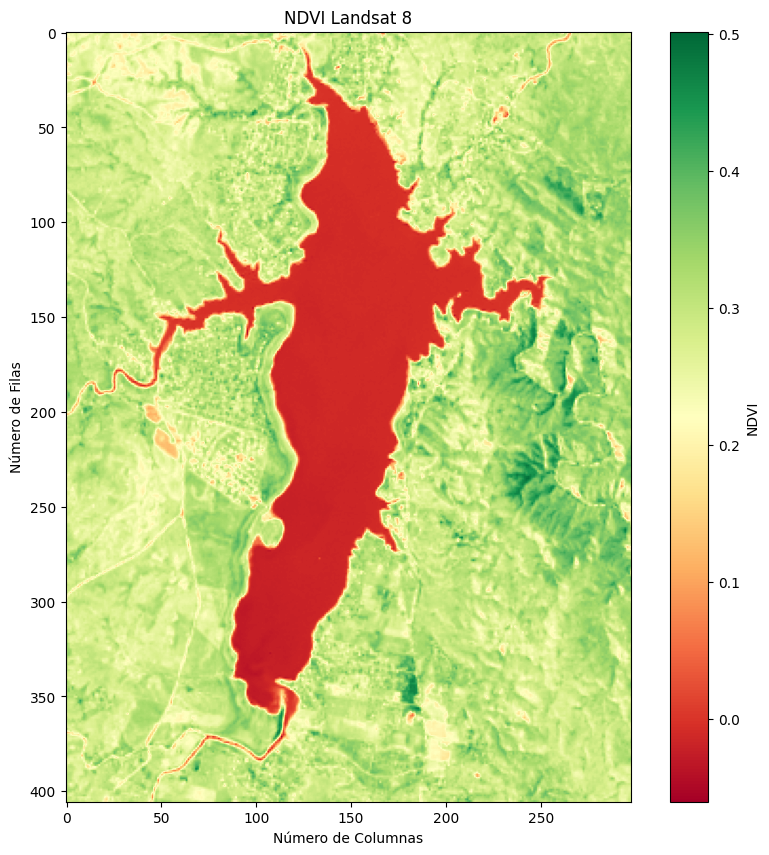

In [36]:
# ndvi.py

import rasterio
import matplotlib.pyplot as plt

ruta_RED = r'.\imagen_extraida\2023-03-11.SR_B4.tif'
ruta_NIR = r'.\imagen_extraida\2023-03-11.SR_B5.tif'

with rasterio.open(ruta_RED) as banda_roja:
    b4 = banda_roja.read(1).astype('float32')

with rasterio.open(ruta_NIR) as banda_nir:
    b5 = banda_nir.read(1).astype('float32')

ndvi = (b5 - b4) / (b5 + b4) # Cálculo del NDVI

# Visualización
plt.figure(figsize=(10, 10))
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar(label='NDVI')
plt.title('NDVI Landsat 8')
plt.xlabel('Número de Columnas')
plt.ylabel('Número de Filas')
# ya se vio previamente que son 406 filas y 298 columnas

plt.show()

Como se observa, la imagen generada no cumple con el objetivo planteado dado que es necesario obtener un índice NDVI únicamente del área del lago y no del terreno externo, por lo que es necesario crear una máscara a fin de aislar exclusivamente el área con presencia de agua. 
Hay varias metodologías para realizar esto, pero la elegida es creando una máscara a partir de la creación de una imagen de índice MNDWI: 
1. Calcular un índice MNDWI.
2. Aislar aquella superficie cuyo valor de pixel del índice MNDWI sea mayor a 0. 
3. Usar esta nueva imagen como máscara.

Las librerías son las mismas que las utilizadas para calcular el NDVI.

<img src=".\anexos\mndwi.jpg" width="600">

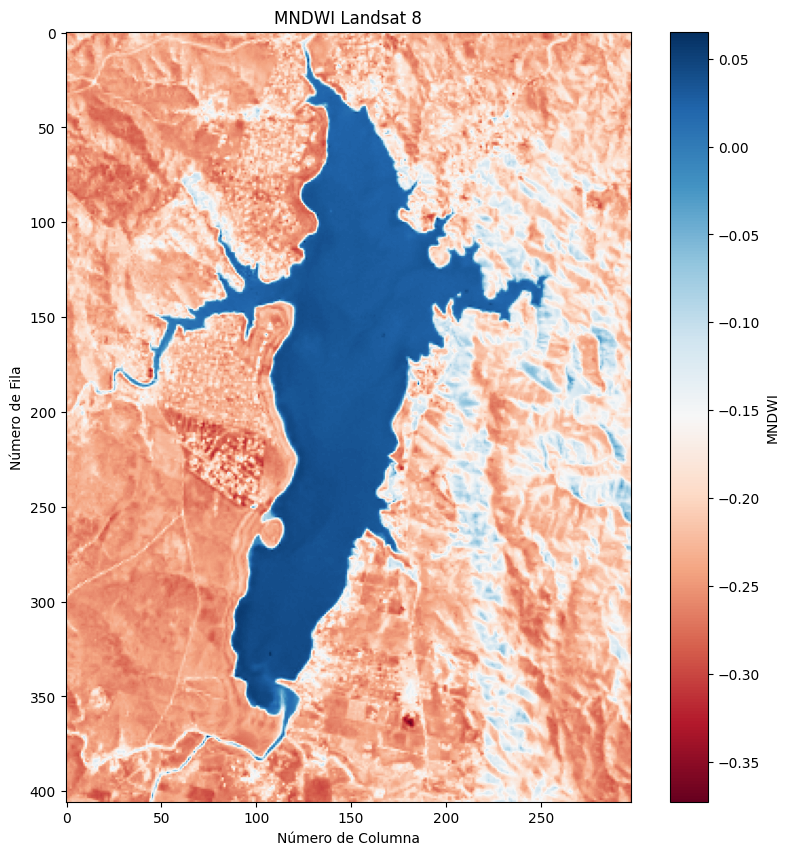

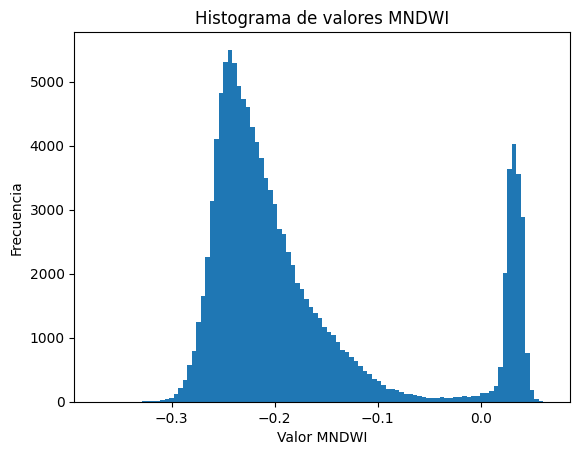

In [37]:
# mndwi.py

ruta_GREEN = r'.\imagen_extraida\2023-03-11.SR_B3.tif'
ruta_SWIR = r'.\imagen_extraida\2023-03-11.SR_B6.tif'

with rasterio.open(ruta_GREEN) as banda_verde:
    b3 = banda_verde.read(1).astype('float32')

with rasterio.open(ruta_SWIR) as banda_swir:
    b6 = banda_swir.read(1).astype('float32')

mndwi = (b3 - b6) / (b3 + b6) # Cálculo del MNDWI

# Visualización
plt.figure(figsize=(10, 10))
plt.imshow(mndwi, cmap='RdBu')
plt.colorbar(label='MNDWI')
plt.title('MNDWI Landsat 8')
plt.xlabel('Número de Columna')
plt.ylabel('Número de Fila')
plt.show()

# Histograma
plt.hist(mndwi[~np.isnan(mndwi)].ravel(), bins=100)
plt.title("Histograma de valores MNDWI")
plt.xlabel("Valor MNDWI")
plt.ylabel("Frecuencia")
plt.show()

A continuación se genera la máscara mediante la siguiente línea de código:

> agua = np.where(condicion, 1, 0)

Esta línea es una expresión booleana que determina qué valores se seleccionarán. En este caso, **condicion** es una máscara booleana donde **True** indica la presencia de agua (MNDWI > 0) y **False** indica la ausencia de agua (MNDWI <= 0). **1** es el valor que se va a seleccionar si la condición es **True**. Dicho de otro modo, cuando haya agua (o sea, cuando el MNDWI sea mayor a 0) la condición será **True**. Finalmente, si la condición es **False**, se utiliza **0**.

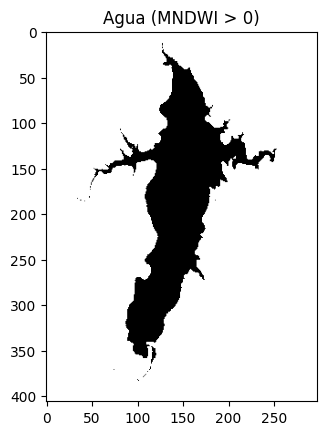

In [38]:
# mascara.py
import numpy as np

condicion = mndwi > 0
agua = np.where(condicion, 1, 0)

# Visualización
plt.imshow(agua, cmap='Greys')
plt.title('Agua (MNDWI > 0)')
plt.show()

Tal como se ve, el resultado obtenido es una imagen binaria en donde 1 representa la zona con agua y 0 el territorio excento de agua.
Con el objetivo de saber si esta máscara es segura para aplicarla al área de estudio, se procedió a calcular los outliers que corresponden a la imagen MNDWI para compararla con dicha máscara.
A falta de más información y desconociendo el área de estudio, para obtener los outliers se calculan los percentiles 25 y 75 del MNDWI para determinar el rango intercuartílico, el que, a su vez, se va a usar para definir los límites inferior y superior de una nueva máscara denominada en el código siguiente como **outliers**. 
Las líneas del tipo **np.percentile(mndwi[~np.isnan(mndwi)], 25)** calculan el valor del primer cuartil (si es 25) y el último (si es 75) excluyendo los valores NaN (Not a Number) de la consideración. 

Límite Inferior: -0.3711763247847557
Límite Superior: -0.024700306355953217


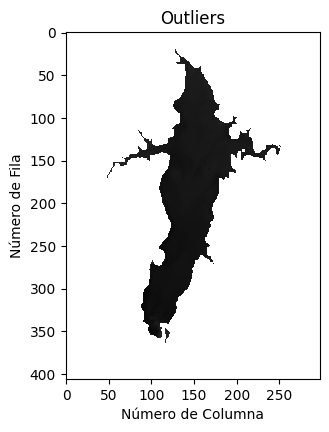

In [50]:
cuantil_1 = np.percentile(mndwi[~np.isnan(mndwi)], 25) 
cuantil_3 = np.percentile(mndwi[~np.isnan(mndwi)], 75)
intercuantilico = cuantil_3 - cuantil_1
limite_inferior = cuantil_1 - 1.5 * intercuantilico
limite_superior = cuantil_3 + 1.5 * intercuantilico

outliers = np.where((mndwi < limite_inferior) | (mndwi > limite_superior), mndwi, np.nan)

print("Límite Inferior:", limite_inferior)
print("Límite Superior:", limite_superior)

plt.figure(figsize=(4.5, 4.5))
plt.imshow(outliers, cmap='Greys')
plt.title('Outliers')
plt.xlabel('Número de Columna')
plt.ylabel('Número de Fila')
plt.show()


Quizá sea preferible visualizar el resultado a la par de la máscara binaria obtenida con anterioridad:

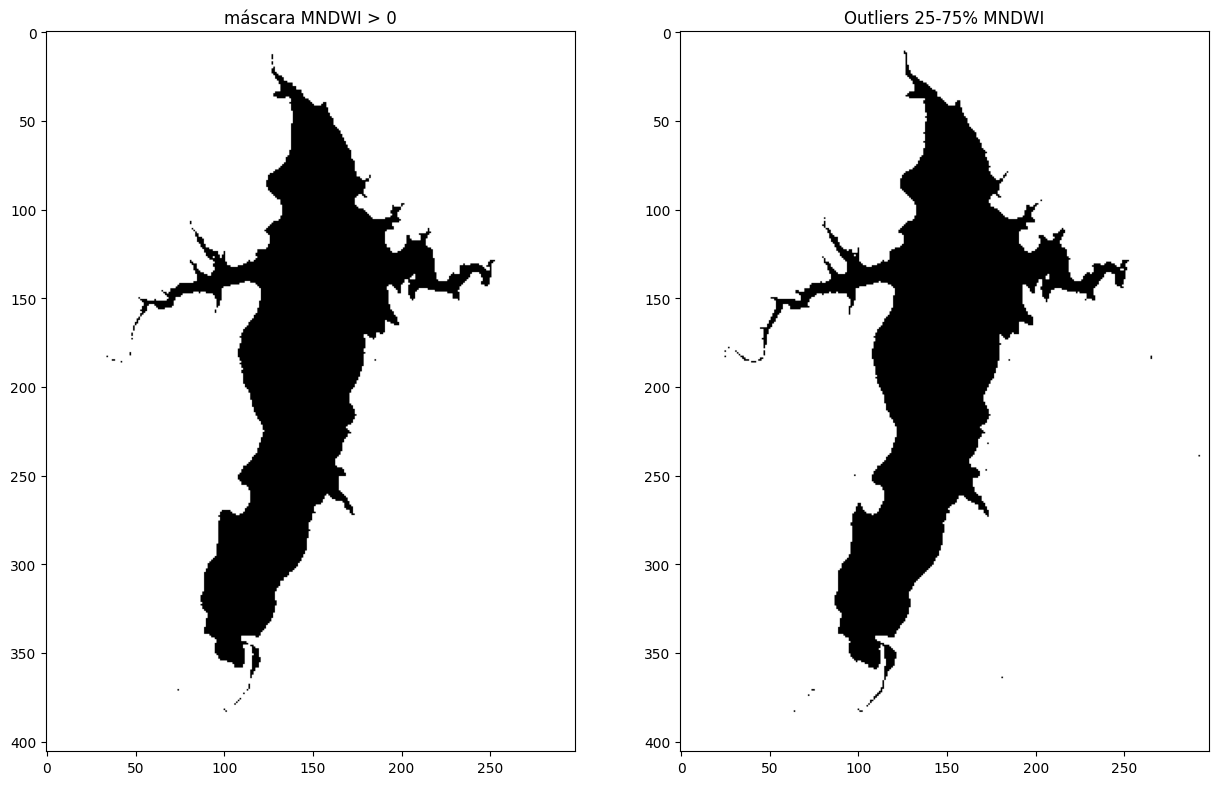

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

axs[0].imshow(agua, cmap='Greys')
axs[0].set_title('máscara MNDWI > 0')

axs[1].imshow(outliers, cmap='Greys')
axs[1].set_title('Outliers 25-75% MNDWI')

plt.show()

Es de notar que la diferencia no es muy grande entre ambas, por lo que se decidió trabajar con la máscara de agua obtenida originalmente.

Tal como se dijo previamente, esta máscara obtenida es binaria: 1 para el agua y 0 para la superficie que no es agua.
Ya obtenida la máscara (**agua**) se logra recortar la imagen MNDWI multiplicando la máscara por dicha imagen MNDWI. Es necesario establecer el valor **0** como **nan**, o sea, valor de no data. Esto se logró mediante la función **nan** que viene con la librería **numpy**.
Aquí se usa la expresión lógica **==** que significa **igual**.

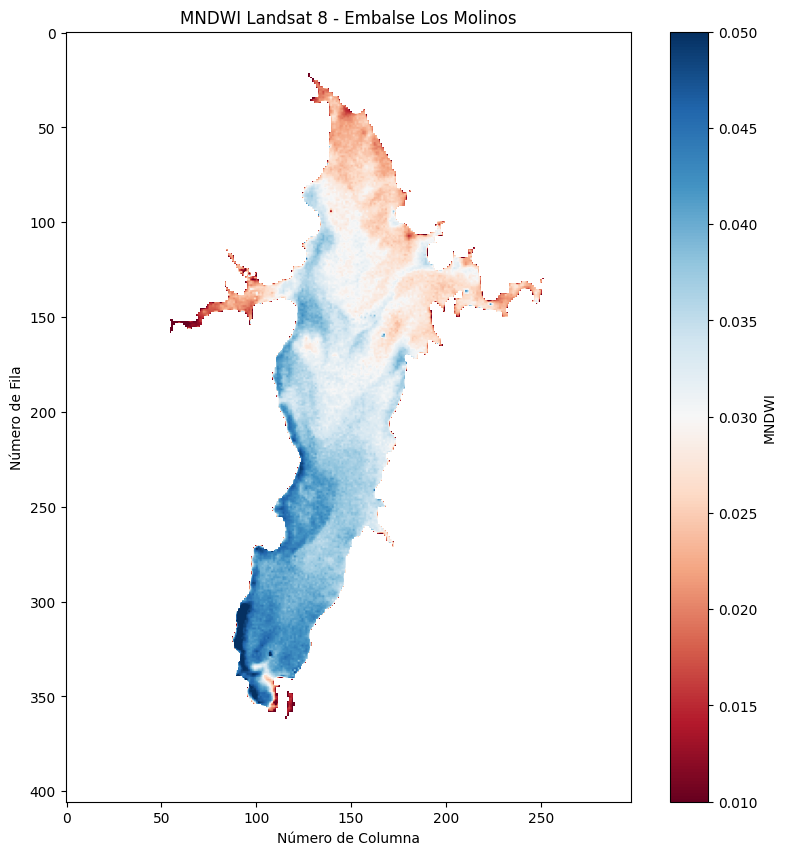

In [41]:
# mndwi_con_mascara.py

mndwi_con_mascara = agua * mndwi

mndwi_con_mascara[(mndwi_con_mascara == 0)] = np.nan

# Visualización
plt.figure(figsize = (10, 10))
plt.imshow(mndwi_con_mascara, cmap = 'RdBu', vmin = 0.01, vmax = 0.05)
plt.colorbar(label = 'MNDWI')
plt.title('MNDWI Landsat 8 - Embalse Los Molinos')
plt.xlabel('Número de Columna')
plt.ylabel('Número de Fila')
plt.show()

Por defecto, Python elige los valores mínimo y máximos (vmin y vmax en el código anterior) como -1 y 1, respectivamente, dado que se está haciendo un cálculo normalizado. Pero eso generaría una imagen con poco contraste entre las diferencias de valores del índice MNDWI. Es por eso que se hace patente la necesidad de visualizar el histograma correspondiente a fines de elegir un valor mínimo y un máximo con mayor precisión. Es por eso que se desarrolló el siguiente script en donde se eligió:
* vmin = 0.01
* vmax = 0.05

Estos valores se llevaron al script anterior. El resultado es la imagen MNDWI suprayacente.

El histograma se construyó con la función **histogram** que viene con la librería **numpy**. Luego se seleccionan sólo los valores válidos de **mndwi_con_mascara**. **np.isnan()** devuelve un booleano que indica dónde hay valores NaN (no válidos), y **~** es el operador de negación, por lo que **~np.isnan(mndwi_con_mascara)** selecciona los valores que no son NaN.

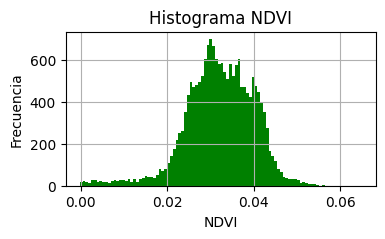

In [42]:
histograma, bordes = np.histogram(mndwi_con_mascara[~np.isnan(mndwi_con_mascara)], bins = 100)

plt.figure(figsize = (4, 2))
plt.bar(bordes[:-1], histograma, width = np.diff(bordes), color='green')
plt.title('Histograma NDVI')
plt.xlabel('NDVI')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

A continuación, se obtiene el producto final objetivo del presente trabajo que es el índice NDVI del Embalse Los Molinos exceptuando el terreno ajeno al lago. 
El siguiente código del archivo **ndvi_con_mascara.py** es exactamente el mismo que **mndwi_con_mascara.py** con el cual se obtuvo el índice MNDWI del lago y no del exterior. Esto es: el producto de la imagen NDVI obtenida en **ndvi.py** por la máscara llamada **agua** obtenida en el archivo **mascara.py**, estableciendo el valor **0** como valor de no data.

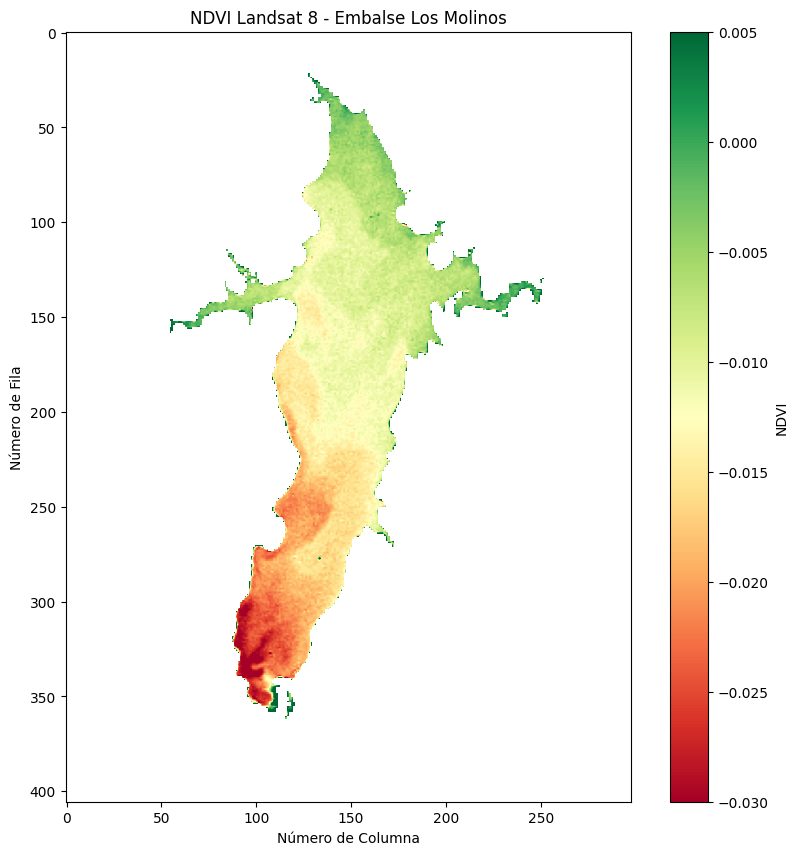

In [43]:
# ndvi_con_mascara.py

ndvi_con_mascara = agua * ndvi

ndvi_con_mascara[(ndvi_con_mascara == 0)] = np.nan

# Visualización
plt.figure(figsize = (10, 10))
plt.imshow(ndvi_con_mascara, cmap='RdYlGn', vmin = -0.03, vmax = 0.005)
plt.colorbar(label = 'NDVI')
plt.title('NDVI Landsat 8 - Embalse Los Molinos')
plt.xlabel('Número de Columna')
plt.ylabel('Número de Fila')
plt.show()

Con la misma lógica comentada anteriormente en la que se hace patente la encesidad de elegir un valor mínimo y un máximo, se construye el histograma de la imagen precedente. El código que se muestra a continuación es el mismo que el usado para obtener el histograma de la imagen MNDWI. 
Los valores obtenidos fueron:
* vmin = -0.03
* vmax = 0.005

Luego, dichos valores son reemplazados en la línea correspondiente para obtener la imagen que se muestra arriba.

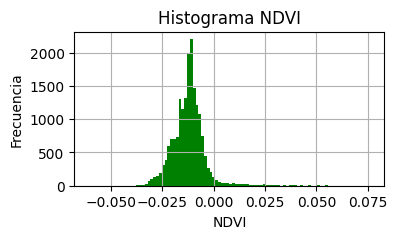

In [44]:
histograma, bordes = np.histogram(ndvi_con_mascara[~np.isnan(ndvi_con_mascara)], bins = 100)

plt.figure(figsize=(4, 2))
plt.bar(bordes[:-1], histograma, width = np.diff(bordes), color = 'green')
plt.title('Histograma NDVI')
plt.xlabel('NDVI')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

Con la finalidad de una mejor visualización y análisis, se muestran ambas imágenes obtenidas una al lado de la otra. 

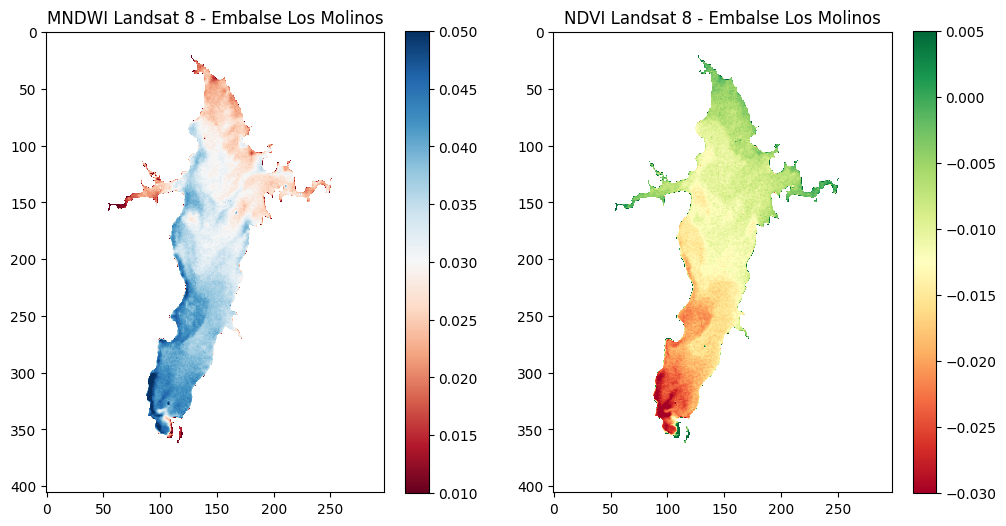

In [45]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# MNDWI
mndwi_1 = axs[0].imshow(mndwi_con_mascara, cmap='RdBu', vmin = 0.01, vmax = 0.05)
axs[0].set_title('MNDWI Landsat 8 - Embalse Los Molinos')
plt.colorbar(mndwi_1, ax=axs[0])

# NDVI
ndvi_1 = axs[1].imshow(ndvi_con_mascara, cmap='RdYlGn', vmin = -0.03, vmax = 0.005)
axs[1].set_title('NDVI Landsat 8 - Embalse Los Molinos')
plt.colorbar(ndvi_1, ax=axs[1])

plt.show()

### Conclusiones:

1. Se observa un progresivo aumento del valor del NDVI en dirección norte del Embalse, ubicándose los valores mínimos de entre -0.03 y -0.02 en el extremo sur del lago, los valores intermedios de alrededor -0.015 y -0.010 en el sector central del lago, y los valores máximos entre -0.010 y 0.005 en el el extremo norte del lago y en los brazos laterales.
2. Consecuentemente, esta variación se corresponde con una progresiva disminución del valor del MNDWI en el sur (aproximadamente 0.05) hacia el norte (aproximadamente 0.01) y los brazos laterales.
3. Una porción de área muy pequeña con alto NDVI (aproximadamente 0.005) se observa en el extremo sur del lago. En esta área se ubica la desembocadura del río Los Reartes, el cual arrastra gran cantidad de sedimentos.
4. En gran parte de la línea de ribera el valor del NDVI es muy alto, de aproximadamente 0.005. Esto tal vez se deba a que el pixel está incluyendo parte del terreno.
5. Las diferencias en los índices expresados anteriormente, quizá se deban a la presencia de localidades y comunas en sus riberas, como Potro de Garay al este y norte del lago, Villa Ciudad de América (noreste del lago), Villa La Merced (este del lago), Solar De Los Molinos (sureste del lago), y Villa Ciudad Parque (sur del lago).
   
   Esto se explica por el mal uso del suelo en la cuenca, en donde se crean las condiciones necesarias para generar una floración de algas tóxicas producto de las fuentes de contaminación antrópica. El resultado es un NDVI positivo representando la eutrofización en agua. 

   El aumento de la eutrofización produce un aumento de la fotosíntesis, lo que en consecuencia hace crecer las algas superficiales, a su vez, disminuye la transparencia del agua y disminuye el oxígeno en el fondo. Esta degradación anaeróbica tiene como resultado, malos olores y pérdida de la biodiversidad (mortandad de peces, entre otros) producto de un incremento de los nutrientes como fósforo y nitrógeno (Ferral, A. et al. 2022: https://www.argentina.gob.ar/sites/default/files/2022/12/ferral_ana.pdf). 


### NOTICIA 1:

Fuente: https://www.resumendelaregion.com/dique-los-molinos-conmocion-por-la-aparicion-de-carpas-muertas-en-la-zona/

<img src=".\anexos\eutrofizacion1.jpg" width="800">

**Cita textual de la noticia**: _"Las causas que originan la proliferación de estas algas tóxicas, mortandad de peces y otros prejuicios económicos de esta contaminación, se deben a la falta de infraestructura para el tratamiento de efluentes cloacales, la deforestación en las Cuencas, falta de previsión y planificación urbana, entre otras causas antrópicas"_.

### NOTICIA 2:

Fuente: https://fibamdp.wordpress.com/2020/02/17/embalse-los-molinos-floracion-de-dolichospermum-sp/

<img src=".\anexos\eutrofizacion2.jpg" width="450">

### NOTICIA 3:

Fuente: https://www.lavoz.com.ar/ciudadanos/lago-los-molinos-el-proceso-de-deterioro-ambiental-se-sigue-acentuando/

<img src=".\anexos\eutrofizacion3.jpg" width="600">